In [1]:
import gym
import tensorflow as tf

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from collections import deque
import numpy as np

def preprocess_observation(obs):
    img = obs
    img = img.mean(axis=2) # to greyscale
    #img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    img = img / 256  # normalize from 0 to 1.
    return img

def show_observation(image, title="Image"):
    plt.figure(figsize=(11, 7))
    plt.subplot(121)
    plt.title(title)
    plt.imshow(image) #cmap="gray"
    plt.axis("off")
    plt.show()

def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum( np.exp(x))
    return ex/sum_ex
    
env = gym.make("SpaceInvaders-v0")
observation = env.reset()
print("obs.shape: " + str(observation.shape)) #obs.shape: (210, 160, 3)
print("env.action_space: " + str(env.action_space)) #env.action_space: Discrete(9)



for step in range(102):
    observation, reward_float, done_bool, info_dict = env.step(1)
    obs_greyscale = preprocess_observation(observation)

#show_observation(observation)
#show_observation(obs_greyscale)
    
print (softmax([1,-2,3]))

test_softmax = softmax([4.3210541e-25, 5.4929095e-33, 5.3535387e-02, 1.2303401e-42, 9.4646466e-01, 1.9473004e-27])
print ("test_softmax: {}".format(test_softmax))

multinomial_action_array = np.random.multinomial(1, test_softmax)
print ("multinomial_action_array: {}".format(multinomial_action_array))



[2018-05-28 08:11:01,816] Making new env: SpaceInvaders-v0


obs.shape: (210, 160, 3)
env.action_space: Discrete(6)
[0.11849965 0.00589975 0.8756006 ]
test_softmax: [0.13103449 0.13103449 0.13824064 0.13103449 0.33762142 0.13103449]
multinomial_action_array: [1 0 0 0 0 0]


In [2]:
from random import randint

eps_min = 0.00
eps_max = 0.5
eps_decay_steps = 25000

def helper_discount_rewards(rewards, discount_rate, begin_index, end_index):
    '''
    Takes in rewards and applies discount rate
    '''
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
        
    relevant_discounted_rewards = discounted_rewards[begin_index:end_index]
    
    reward_mean = relevant_discounted_rewards.mean()
    reward_std = relevant_discounted_rewards.std()
        
    #return discounted_rewards
    return [(discounted_reward - reward_mean)/reward_std for discounted_reward in discounted_rewards]

def epsilon_greedy(optimal_action, number_outputs, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    
    if step % 1000 == 0:
        print("step: " + str(step) + ", epsilon: " + str(epsilon))
        
    if np.random.rand() < epsilon:
        return np.random.randint(number_outputs-1) # random action
    else:
        return optimal_action # optimal action

print("epsilon_greedy(4): " + str(epsilon_greedy(4,9,50))) 
print("epsilon_greedy(4): " + str(epsilon_greedy(4,9,5000)))
print("epsilon_greedy(4): " + str(epsilon_greedy(4,9,500000)))
    
def action_to_one_hot(action, possible_action_count, reward):
    #9 possible positions of the joystick 
    #(0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left)
    
    return_array = np.zeros(possible_action_count)
    action_int = int(action)
    
    return_array[action_int] = 1.0

    return return_array


#(0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left)
def action_to_string(action):
    if action == 0:
        return "center"
    if action == 1:
        return "up"
    if action == 2:
        return "right"
    if action == 3:
        return "left"
    if action == 4:
        return "down"
    if action == 5:
        return "upper-right"
    if action == 6:
        return "upper-left"
    if action == 7:
        return "lower-right"
    if action == 8:
        return "lower-left"
    else:
        return "unknown"


print("action_to_one_hot(3, 9, 1): " + str(action_to_one_hot(3.0, 9, 1)))
print("action_to_one_hot(9, 9, .8): " + str(action_to_one_hot(8, 9, 0.8)))
print("action_to_string(5): " + str(action_to_string(5)))


epsilon_greedy(4): 2
step: 5000, epsilon: 0.4
epsilon_greedy(4): 4
step: 500000, epsilon: 0.0
epsilon_greedy(4): 4
action_to_one_hot(3, 9, 1): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
action_to_one_hot(9, 9, .8): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
action_to_string(5): upper-right


In [3]:
saver_file = "./models/space_invaders_rl"

height = 210 * 5
width = 160
channels = 1
#frames_captured = 5

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 2
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

n_hidden_in = 64 * 263 * 40  # conv3 has 64 maps of 525x80 each

n_inputs = 6
n_outputs = 6
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = 256
n_hidden4 = 256
n_hidden5 = 256
n_hidden6 = 256
n_hidden7 = 128
n_hidden8 = 64

#learning_rate=.000002
learning_rate =.00000003

dropout_keep_prob = 1.0

tf.reset_default_graph()

#with tf.name_scope("inputs"):
#tf_input_frame = tf.placeholder(tf.float32, shape=(None, height * width * channels))
tf_input_frame = tf.placeholder(tf.float32, shape=(None, height, width, channels))
tf_input_value = tf.placeholder(tf.float32, shape=(None, n_inputs))
tf_input_learning_rate = tf.placeholder(tf.float32)
tf_dropout_keep_prob = tf.placeholder(tf.float32)
tf_reward = tf.placeholder(tf.float32)
    
#with tf.name_scope("hidden"):
initializer = tf.contrib.layers.variance_scaling_initializer()


convs = [16,32]
kerns = [8,8]
strides = [4,4]
pads = 'valid'
activ = tf.nn.elu

# Policy Network
conv1 = tf.layers.conv2d(
        inputs = tf_input_frame,
        filters = convs[0],
        kernel_size = kerns[0],
        strides = strides[0],
        padding = pads,
        activation = activ,
        name='conv1')

conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters = convs[1],
        kernel_size = kerns[1],
        strides = strides[1],
        padding = pads,
        activation = activ,
        name='conv2')

flat = tf.layers.flatten(conv2)



hidden1 = tf.layers.dense(flat, n_hidden1, activation=tf.nn.elu, name="hidden1", kernel_initializer=initializer)
#hidden1_drop = tf.nn.dropout(hidden1, tf_dropout_keep_prob)
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2", kernel_initializer=initializer)
#hidden2_drop = tf.nn.dropout(hidden2, tf_dropout_keep_prob)
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu, name="hidden3", kernel_initializer=initializer)

hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.elu, name="hidden4", kernel_initializer=initializer)

hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.elu, name="hidden5", kernel_initializer=initializer)

hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.nn.elu, name="hidden6", kernel_initializer=initializer)

hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=tf.nn.elu, name="hidden7", kernel_initializer=initializer)

hidden8 = tf.layers.dense(hidden7, n_hidden8, activation=tf.nn.elu, name="hidden8", kernel_initializer=initializer)

#with tf.name_scope("output"):
logits = tf.layers.dense(hidden8, n_outputs, name="output")

#with tf.name_scope("train"):
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf_input_value, logits=logits)
#loss = tf.reduce_mean(cross_entropy)
loss = tf.reduce_mean(tf.square(logits-tf_input_value))
optimizer = tf.train.AdamOptimizer(tf_input_learning_rate)
training_op = optimizer.minimize(loss)

print ("hidden1: " + str(hidden1))
print ("hidden2: " + str(hidden2))
print ("hidden3: " + str(hidden3))
print ("logits: " + str(logits))


hidden1: Tensor("hidden1/Elu:0", shape=(?, 512), dtype=float32)
hidden2: Tensor("hidden2/Elu:0", shape=(?, 256), dtype=float32)
hidden3: Tensor("hidden3/Elu:0", shape=(?, 256), dtype=float32)
logits: Tensor("output/BiasAdd:0", shape=(?, 6), dtype=float32)


In [ ]:
import math

load_model_before_training = True
env = gym.make("SpaceInvaders-v0")
n_epochs = 2001
global_step = 0

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
   
    if load_model_before_training:
        print("Loading existing model before training: {}".format(saver_file))
        saver.restore(sess, saver_file)
    else:
        print("Creating new model before training: {}".format(saver_file))
        sess.run(init)
    
    for epoch in range(n_epochs):  #play n_epochs games
        observation = env.reset()
        temp_lives = 3
        score = 0.0
        frames = np.empty([210, 160, 0])
        actions = np.empty([0])
        rewards = np.empty([0])
        all_logits = []
        
        #get the first frame
        input_value = 0  #set an initial input value
        #observation, reward_float, done_bool, info_dict = env.step(input_value)
        obs_greyscale = preprocess_observation(observation)
        obs_greyscale_reshape = np.reshape(obs_greyscale, (210,160,1))
        frames = np.append(frames, obs_greyscale_reshape, axis=2)
        actions = np.append(actions, input_value)
        last_action_step = 0
        decision_step_counter = 0
    
        
        game_step_counter = 0
        action_from_ai_epsilon_greedy = 0
        
        #play the game until the first death, recording the frames along the way
        while True:
            #this_frame = frames[:,:,np.ma.size(frames, axis=2)-1]
            #this_flattened_frame = this_frame.flatten()
            #this_flattened_frame_reshaped = np.reshape(this_flattened_frame, (1, this_flattened_frame.size))
            
            num_frames = np.ma.size(frames, axis=2)
                       
            concatenated_frames = frames[:,:,num_frames-1]
            
            for j in range(1,5,1):
                if num_frames-j <= 1:
                    this_frame = frames[:,:,0]
                elif j >= num_frames:
                    this_frame = frames[:,:,num_frames-1]
                else:
                    this_frame = frames[:,:,num_frames-1-j]
                concatenated_frames = np.append(concatenated_frames, this_frame, axis=0)
            
            #concatenated_frames_reshaped = np.reshape(concatenated_frames, (1, 210*5*160))
            concatenated_frames_reshaped = np.reshape(concatenated_frames, (1, height, width, 1))
            
            #todo - write a function to build the concatenated_frames
            
            #use the input value from the AI
            temp_input = [0,0,0,0,0,0]
            temp_input[action_from_ai_epsilon_greedy] = 1
            temp_input_reshaped = np.reshape(temp_input, (1, len(temp_input)))
            
            #tf_dropout_keep_prob: 1.0,
            feed_dict = {tf_input_frame : concatenated_frames_reshaped, 
                         tf_input_value : temp_input_reshaped,
                         tf_input_learning_rate: 0.0,
                         tf_dropout_keep_prob: 1.0,
                         tf_reward: 0.0}
            logits_out = sess.run([logits], feed_dict=feed_dict)
            #all_gradients.append(gradients_out)
            #all_variables.append(variables_out)

            all_logits.append(logits_out[0])
            
            #if global_step % 5 == 0:  #only allow a change of direction every 5 steps.  
            action_from_ai_logits_argmax = np.argmax(logits_out[0])
            
#             print(str(logits_out[0]) + ": " + str(np.argmax(logits_out[0])))
            
#             print("output_probability_out: " + str(output_probability_out))
#             print("action_from_ai_logits_argmax: " + str(action_from_ai_logits_argmax) + ", action_from_ai: " + str(action_from_ai), ", numpy_choice: " + str(numpy_choice))
#             print("var: " + str(var_out))
             
    
#            print ("logits_out[0]: {}".format(logits_out[0]))
    
            positive_logits = logits_out[0] + abs(np.amin(logits_out[0]))
            softmax_logits = softmax(positive_logits / np.amax(positive_logits))
#            print ("softmax_logits[0]: {}".format(softmax_logits[0]))

            try:
                multinomial_action_array = np.random.multinomial(1, softmax_logits[0])
                action_from_multinomial_action = np.argmax(multinomial_action_array)
#                print ("multinomial_action_array: {}".format(multinomial_action_array))
            except ValueError:
                #I have no idea why this occassionally errors out.
                action_from_multinomial_action = np.argmax(softmax_logits)
#                print ("multinomial error, using action {}".format(action_from_multinomial_action))

#            print ("action_from_multinomial_action: {}".format(action_from_multinomial_action))
        
            # decide which action to use
            if epoch % 2 == 0:
#                print("Using strict AI actions")
                action_from_ai_epsilon_greedy = action_from_ai_logits_argmax  #do what the AI says
            else:
#                print("Using probability-based actions")
                action_from_ai_epsilon_greedy = action_from_multinomial_action  #use probability-based action
            #action_from_ai_epsilon_greedy = action_from_ai  #do what the AI says with probabilities using tf.multinomial probabilities
            #action_from_ai_epsilon_greedy = numpy_choice #do what the AI says with probabilities using numpy  probabilities
                
            #run the next step given the input from the logits
            observation, reward_float, done_bool, info_dict = env.step(action_from_ai_epsilon_greedy)
            
            #add this frame to our frame buffer
            obs_greyscale = preprocess_observation(observation)
            obs_greyscale_reshape = np.reshape(obs_greyscale, (210,160,1))
            frames = np.append(frames, obs_greyscale_reshape, axis=2)
            actions = np.append(actions, action_from_ai_epsilon_greedy)
            rewards = np.append(rewards, reward_float)
            score = score + reward_float
            
            lives = info_dict['ale.lives']

            if done_bool:
                break
                
            if lives != temp_lives:  #we lost a life.  consider this game over.
                temp_lives = lives
                rewards[-25] = -40
#                 if score > 0.0:
#                     rewards[-25] = -0.25 * score #-20  #negative reward for death
#                 else:
#                     rewards[-25] = -20
#                break

            if epoch % 1 == 0:
                env.render()  #display the current frame.
                
            decision_step_counter += 1
            game_step_counter += 1
            global_step += 1
        
        if epoch % 50 == 0 and epoch > 0:
            print("Saving model at epoch {}: {}".format(epoch, saver_file))
            saver.save(sess, saver_file)
        
        #now, the game is over and we have frames, assign a reward for each frame.
        #the last 10 frames will have a decreasing reward.
        
        num_frames = np.ma.size(frames, axis=2)
        frames_to_skip_begin = 0
        frames_to_skip_end  = 0  #number of frames between pacman being eaten and game reset
    
#        print("rewards: {}".format(rewards))
        discounted_rewards = helper_discount_rewards(rewards, 0.97, frames_to_skip_begin, num_frames) #-1-frames_to_skip_end
        discounted_rewards_median = np.median(discounted_rewards)
        discounted_rewards_mean = np.mean(discounted_rewards)
        
        display_actions = np.zeros(6)
        ai_actions = np.zeros(6)
        loss_out_sum = 0.0
        frames_taught = 0.000000001
        
        skipped_frames = 0
        temp_action = 0
        
        reward_frame_counter = 0
        punish_frame_counter = 0
            
        frames_to_train = np.arange(num_frames-1-frames_to_skip_end)
        np.random.shuffle(frames_to_train)
        
        for i in range(frames_to_skip_begin, num_frames-1-frames_to_skip_end):   #skip the first frames

            this_random_frame_index = frames_to_train[i]

            if i >= num_frames-1-frames_to_skip_end: 
                continue  #only train if frame is not during pacman's death throws 
            
            if True: 
#                 concatenated_frames = frames[:,:,i]
#                 for j in range(-1,-5,-1):
#                     this_frame = frames[:,:,i+j]
#                     this_flattened_frame = this_frame.flatten()
#                     concatenated_frames = np.append(concatenated_frames, this_frame, axis=0)

                concatenated_frames = frames[:,:,this_random_frame_index]
                for j in range(-1,-5,-1):
                    this_frame = frames[:,:,this_random_frame_index+j]
                    this_flattened_frame = this_frame.flatten()
                    concatenated_frames = np.append(concatenated_frames, this_frame, axis=0)
                    
#                concatenated_frames_reshaped = np.reshape(concatenated_frames, (1, 210*5*160))
                concatenated_frames_reshaped = np.reshape(concatenated_frames, (1, height, width, 1))
            
#                action_taken_one_hot = action_to_one_hot(actions[i], n_outputs, rewards[i])
                action_taken_one_hot = action_to_one_hot(actions[this_random_frame_index], n_outputs, rewards[this_random_frame_index])
                display_actions = np.add(display_actions, action_taken_one_hot)
                
                #reward_for_frame = discounted_rewards[i] + (-1.0 * abs(discounted_rewards_median))  # hopefully, adding the median will keep the AI from getting stuck taking one action
                #reward_for_frame = discounted_rewards[i] - .05
                reward_for_frame = discounted_rewards[this_random_frame_index]
                #print("reward for frame {} is {}.  action: {}".format(i, reward_for_frame, action_taken_one_hot_reshaped))
            
#                 print("training on frame: " + str(i) + ", action: " + action_to_string(actions[i]) + 
#                       ", prev action: " + action_to_string(actions[i-1]) + " " +
#                       str(prev_action_taken_one_hot_reshaped) + " " + 
#                       str(action_taken_one_hot_reshaped))
                
#                 if reward_for_frame > discounted_rewards_median:
#                     reward_for_frame = 1
#                     reward_frame_counter +=1
#                     print('R', end='')
#                 else:
#                     action_taken_one_hot = action_taken_one_hot * -1
#                     reward_for_frame = 1
#                     punish_frame_counter += 1
#                     print('P', end='')
                
                action_taken_one_hot = action_taken_one_hot * reward_for_frame
    
                action_taken_one_hot_reshaped = np.reshape(action_taken_one_hot, (1, len(action_taken_one_hot)))
    
#                print(action_taken_one_hot_reshaped)
                
                feed_dict = {tf_input_frame : concatenated_frames_reshaped, 
                             tf_input_value : action_taken_one_hot_reshaped,
                             tf_input_learning_rate: learning_rate,
                             tf_dropout_keep_prob: dropout_keep_prob,
                             tf_reward: reward_for_frame}
                loss_out, _, logits_out = sess.run([loss, training_op, logits], feed_dict=feed_dict)

                frames_taught = frames_taught + 1
                loss_out_sum += loss_out

                action_from_ai = np.argmax(logits_out[0])
                action_from_ai_one_hot = action_to_one_hot(action_from_ai, n_outputs, rewards[i])
                ai_actions = np.add(ai_actions, action_from_ai_one_hot)
            else:
                skipped_frames = skipped_frames + 1
            
            temp_action = actions[i]
#             if epoch % 10 == 0:
#                 print("ai action[" + str(i) + "]: " + str(actions[i]) + ", action_taken_one_hot: " + 
#                       str(action_taken_one_hot_reshaped) + ", loss_out: " + str(loss_out))
#                 print("logits: " + str(logits_out[0]))
        
        print("Epoch: " + str(epoch) + ", frames: " + str(num_frames) + ", score: " + str(score) + ", average loss: " + str(loss_out_sum/frames_taught))
        #print("actions trained: {}, rewards: {}, punishments: {}, median: {}, mean: {}".format(display_actions, reward_frame_counter, punish_frame_counter, discounted_rewards_median, discounted_rewards_mean))
        print("actions trained:           {}".format(display_actions))
        print("actions out while training:{}".format(ai_actions))
        #print("discounted_rewards: " + str(discounted_rewards))
        #TODO - should learning rate decrease over time?
        print("")


[2018-05-28 08:11:24,810] Making new env: SpaceInvaders-v0


Loading existing model before training: ./models/space_invaders_rl
Epoch: 0, frames: 796, score: 340.0, average loss: 0.15363647851260212
actions trained:           [ 41. 228.  47.  91. 294.  94.]
actions out while training:[ 40. 230.  50.  84. 298.  93.]

Epoch: 1, frames: 578, score: 115.0, average loss: 0.1728642263668517
actions trained:           [ 92.  95.  80.  97. 138.  75.]
actions out while training:[ 61.  63.   0. 113. 322.  18.]

Epoch: 2, frames: 1460, score: 550.0, average loss: 0.1611663180747324
actions trained:           [ 91. 660. 141.  95. 392.  80.]
actions out while training:[ 84. 661. 138. 102. 390.  84.]

Epoch: 3, frames: 885, score: 220.0, average loss: 0.16719372098863913
actions trained:           [111. 172. 148. 132. 168. 153.]
actions out while training:[ 22. 319.  13.  56. 364. 110.]

Epoch: 4, frames: 667, score: 420.0, average loss: 0.15418397499992248
actions trained:           [ 13. 180.   1.  81. 265. 126.]
actions out while training:[ 17. 168.   0.  

Epoch: 43, frames: 662, score: 155.0, average loss: 0.1687555075410299
actions trained:           [ 85. 108.  84. 135. 139. 110.]
actions out while training:[  0.  65.  32. 204. 302.  58.]

Epoch: 44, frames: 727, score: 155.0, average loss: 0.16282447092041086
actions trained:           [ 92.  67.  63. 165. 244.  95.]
actions out while training:[ 90.  74.  60. 165. 252.  85.]

Epoch: 45, frames: 742, score: 150.0, average loss: 0.1629915983057625
actions trained:           [116. 134. 119. 137. 148.  87.]
actions out while training:[  0. 224.  63. 118. 318.  18.]

Epoch: 46, frames: 613, score: 180.0, average loss: 0.15295517851873974
actions trained:           [  1.  28.  73.  39. 416.  55.]
actions out while training:[  0.  29.  71.  41. 416.  55.]

Epoch: 47, frames: 798, score: 240.0, average loss: 0.16499116637970818
actions trained:           [100. 143. 128. 155. 160. 111.]
actions out while training:[  0. 125. 107. 105. 430.  30.]

Epoch: 48, frames: 1065, score: 745.0, average 

Epoch: 86, frames: 619, score: 195.0, average loss: 0.13420408620437047
actions trained:           [ 35.  85.  17.  38. 349.  94.]
actions out while training:[ 41.  78.  15.  39. 358.  87.]

Epoch: 87, frames: 361, score: 70.0, average loss: 0.16814984867056793
actions trained:           [64. 70. 62. 55. 63. 46.]
actions out while training:[  0.  39.  35. 139. 144.   3.]

Epoch: 88, frames: 537, score: 100.0, average loss: 0.1587404443055415
actions trained:           [  2.  97.  34.  55. 233. 115.]
actions out while training:[  1. 105.  29.  55. 234. 112.]

Epoch: 89, frames: 1171, score: 260.0, average loss: 0.16940206192704424
actions trained:           [153. 223. 191. 210. 201. 192.]
actions out while training:[  9. 358. 164. 104. 349. 186.]

Epoch: 90, frames: 1246, score: 390.0, average loss: 0.15418929348809624
actions trained:           [ 19. 350. 193. 185. 437.  61.]
actions out while training:[ 25. 319. 201. 201. 430.  69.]

Epoch: 91, frames: 470, score: 105.0, average loss:

Epoch: 129, frames: 543, score: 185.0, average loss: 0.16312542716157166
actions trained:           [ 87. 106.  70.  96.  97.  86.]
actions out while training:[ 18.  64.  40. 105. 252.  63.]

Epoch: 130, frames: 369, score: 105.0, average loss: 0.15766742373754844
actions trained:           [  1.  81.  12.  46.  87. 141.]
actions out while training:[  0.  81.  14.  47.  82. 144.]

Epoch: 131, frames: 925, score: 125.0, average loss: 0.16510395346415108
actions trained:           [146. 128. 131. 166. 181. 172.]
actions out while training:[  8. 101.  27. 157. 449. 182.]

Epoch: 132, frames: 391, score: 90.0, average loss: 0.15866090667614247
actions trained:           [  2. 100.  94.  26. 109.  59.]
actions out while training:[ 10.  84.  91.  29. 113.  63.]

Epoch: 133, frames: 850, score: 170.0, average loss: 0.15922241752334493
actions trained:           [150. 122. 131. 147. 157. 142.]
actions out while training:[122. 129.  49.  76. 227. 246.]

Epoch: 134, frames: 538, score: 160.0, av

Epoch: 172, frames: 735, score: 285.0, average loss: 0.1675045671664501
actions trained:           [146. 124.  28.  52. 276. 108.]
actions out while training:[136. 130.  33.  55. 275. 105.]

Epoch: 173, frames: 677, score: 155.0, average loss: 0.16329517681306144
actions trained:           [110. 114.  96. 132. 125.  99.]
actions out while training:[ 58. 143.   0.  48. 341.  86.]

Epoch: 174, frames: 727, score: 220.0, average loss: 0.15890290899145745
actions trained:           [ 54. 206.  24.  16. 344.  82.]
actions out while training:[ 55. 206.  26.  16. 336.  87.]

Epoch: 175, frames: 555, score: 35.0, average loss: 0.16841219553920428
actions trained:           [ 87.  94.  81.  86. 115.  91.]
actions out while training:[ 50.  76.   0.  30. 278. 120.]

Epoch: 176, frames: 916, score: 225.0, average loss: 0.15173412474260312
actions trained:           [ 72. 371.  49.  99. 209. 115.]
actions out while training:[ 76. 338.  63. 107. 218. 113.]

Epoch: 177, frames: 698, score: 165.0, ave

Epoch: 215, frames: 805, score: 115.0, average loss: 0.1652996355102546
actions trained:           [154. 133. 100. 142. 156. 119.]
actions out while training:[115. 158.   9. 103. 367.  52.]

Epoch: 216, frames: 1297, score: 330.0, average loss: 0.14257160473372088
actions trained:           [ 14. 495.  17.  39. 575. 156.]
actions out while training:[ 17. 510.  18.  38. 575. 138.]

Epoch: 217, frames: 1131, score: 540.0, average loss: 0.1624220917108103
actions trained:           [185. 214. 172. 188. 198. 173.]
actions out while training:[146. 372.  36.  58. 369. 149.]

Epoch: 218, frames: 1014, score: 335.0, average loss: 0.1862995834695336
actions trained:           [ 26. 343.  37. 140. 355. 112.]
actions out while training:[ 22. 358.  37. 129. 347. 120.]

Epoch: 219, frames: 535, score: 100.0, average loss: 0.16159023833072497
actions trained:           [ 87. 105.  74.  72.  80. 116.]
actions out while training:[ 61. 150.  69.  52. 114.  88.]

Epoch: 220, frames: 1168, score: 420.0, 

Epoch: 258, frames: 1456, score: 600.0, average loss: 0.17046776125163823
actions trained:           [215. 574. 162. 121. 314.  69.]
actions out while training:[179. 636. 143. 117. 301.  79.]

Epoch: 259, frames: 827, score: 185.0, average loss: 0.16592188319777285
actions trained:           [136. 152. 122. 141. 157. 118.]
actions out while training:[ 90. 251.  46. 126. 284.  29.]

Epoch: 260, frames: 879, score: 305.0, average loss: 0.16164346591187176
actions trained:           [ 14. 274.  72.  41. 359. 118.]
actions out while training:[ 14. 218.  80.  43. 423. 100.]

Epoch: 261, frames: 545, score: 70.0, average loss: 0.1632316534132979
actions trained:           [ 86.  90. 109.  60. 103.  96.]
actions out while training:[ 39. 103.  47.  28. 239.  88.]

Epoch: 262, frames: 1102, score: 405.0, average loss: 0.15406747795774534
actions trained:           [ 68. 431. 146.  77. 303.  76.]
actions out while training:[ 84. 394. 120.  88. 355.  60.]

Epoch: 263, frames: 500, score: 60.0, av

Epoch: 301, frames: 620, score: 110.0, average loss: 0.16729934530891308
actions trained:           [101. 116.  87.  98.  96. 121.]
actions out while training:[ 22.  64.   7.  63. 251. 212.]

Epoch: 302, frames: 1123, score: 615.0, average loss: 0.1407707363625011
actions trained:           [ 66. 338. 147.  33. 320. 218.]
actions out while training:[ 72. 315. 151.  38. 322. 224.]

Epoch: 303, frames: 769, score: 215.0, average loss: 0.16595192410101534
actions trained:           [116. 150. 119. 123. 123. 137.]
actions out while training:[ 22. 290.  17.  64. 241. 134.]

Epoch: 304, frames: 385, score: 105.0, average loss: 0.165483532055897
actions trained:           [ 74.  52.   1.   2.  78. 177.]
actions out while training:[ 70.  60.   0.   6.  79. 169.]

Epoch: 305, frames: 680, score: 155.0, average loss: 0.1644807522524791
actions trained:           [ 91. 128.  98. 113. 122. 127.]
actions out while training:[ 21. 165.  26.  90. 243. 134.]

Epoch: 306, frames: 656, score: 190.0, aver

Epoch: 344, frames: 1398, score: 490.0, average loss: 0.1648671725432361
actions trained:           [ 71. 735.  53. 179. 277.  82.]
actions out while training:[ 70. 767.  44. 170. 261.  85.]

Epoch: 345, frames: 1111, score: 315.0, average loss: 0.16630896392296426
actions trained:           [182. 238. 167. 180. 183. 160.]
actions out while training:[ 59. 632.  77.  87. 227.  28.]

Epoch: 346, frames: 682, score: 185.0, average loss: 0.14140612564316452
actions trained:           [  4. 179.   2.  63. 321. 112.]
actions out while training:[  4. 177.   1.  61. 319. 119.]

Epoch: 347, frames: 657, score: 95.0, average loss: 0.16311038112570717
actions trained:           [105. 138.  85. 118. 125.  85.]
actions out while training:[ 43. 282.   4.  33. 246.  48.]

Epoch: 348, frames: 364, score: 85.0, average loss: 0.16115582773568113
actions trained:           [  3. 127.   0.  21. 107. 105.]
actions out while training:[  2. 127.   0.  21. 109. 104.]

Epoch: 349, frames: 701, score: 205.0, av

Epoch: 387, frames: 554, score: 125.0, average loss: 0.16270596358382444
actions trained:           [ 84. 126.  87.  92.  73.  91.]
actions out while training:[ 98. 183.  65.  70. 131.   6.]

Epoch: 388, frames: 980, score: 535.0, average loss: 0.17876197127106763
actions trained:           [106. 415. 137.  62. 242.  17.]
actions out while training:[114. 386. 161.  63. 236.  19.]

Epoch: 389, frames: 933, score: 195.0, average loss: 0.17487003249554647
actions trained:           [129. 181. 154. 157. 149. 162.]
actions out while training:[ 19. 370. 148. 101. 247.  47.]

Epoch: 390, frames: 766, score: 175.0, average loss: 0.11477907413759277
actions trained:           [ 78. 169. 140.  80. 268.  30.]
actions out while training:[ 81. 167. 138.  80. 271.  28.]

Epoch: 391, frames: 583, score: 100.0, average loss: 0.1695642494703892
actions trained:           [ 92.  93. 102. 107.  89.  99.]
actions out while training:[ 71.  22. 104. 114. 183.  88.]

Epoch: 392, frames: 706, score: 235.0, av

In [12]:
#set above epochs to 1.  
#create a concatenated image of the last 5 frames


#concatenated_frames = frames[:,:,num_frames-40]

# for j in range(1,6):
#     this_frame = frames[:,:,num_frames-40+j]
#     print("this_frame: " + str(this_frame.shape))
#     concatenated_frames = np.append(concatenated_frames, this_frame, axis=0)
#     print(str(concatenated_frames.shape))

    
print(concatenated_frames)
#print the image
#show_observation(concatenated_frames)



[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [63.66666667 63.66666667 63.66666667 ... 63.66666667 63.66666667
  63.66666667]
 [63.66666667 63.66666667 63.66666667 ... 63.66666667 63.66666667
  63.66666667]
 [63.66666667 63.66666667 63.66666667 ... 63.66666667 63.66666667
  63.66666667]]


num_frames: 158


<IPython.core.display.Javascript object>


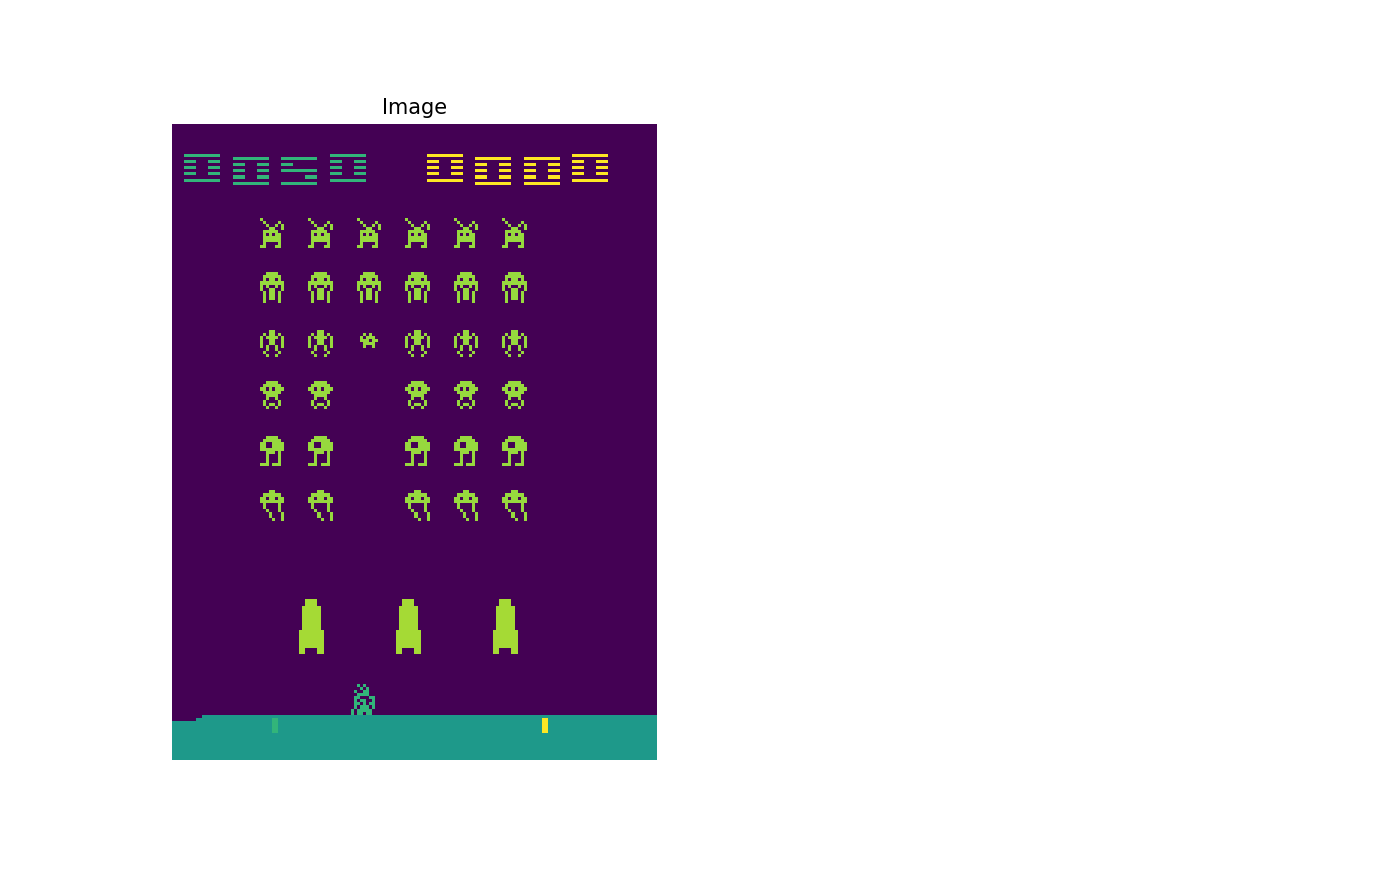

In [7]:
print("num_frames: " + str(num_frames))


show_observation(frames[:,:,125])
#show_observation(concatenated_frames)


#print("rewards: " + str(rewards))
#rint("discounted_rewards: " + str(discounted_rewards))
#print("action_taken_one_hot_reshaped: " + str(action_taken_one_hot_reshaped))
#rint("all_logits: " + str(all_logits))



# num_frames = np.ma.size(frames, axis=2)

# X_input = np.empty([n_steps, 210 * 160])
# input_index = 0

# for i in range(num_frames, num_frames-n_steps, -1):
#     this_frame = frames[:,:,i-1]
#     X_input[input_index] = this_frame.flatten()
#     input_index = input_index + 1
    
#obs_greyscale_reshape.shape



#show_observation(obs_greyscale_reshape[:,:,0])

In [ ]:
y_input = np.empty([n_steps, 10])
for i in range(0,  29):
    y_input[i] = np.zeros(10)
    
y_input  

In [28]:
#len(rewards)
#len(actions)

In [8]:
all_logits

[array([ 180.31735229, -245.90328979,  -55.46500015,  -39.02265549,
        -171.08708191,   39.90904999, -253.30400085,   10.52585697,
           9.43663216], dtype=float32)]

In [6]:
#len(all_gradients)
np.shape(all_gradients)

(6, 10)

In [6]:
import sys
print(sys.getsizeof(all_variables))
#np.shape(all_gradients[1])
#all_gradients
#all_variables

128


In [8]:

import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

get_size(all_variables)

8392